# Functional Connectivity Analysis with Nilearn

This script closely follows [this example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) provided through the Nilearn tutorials site.

In [1]:
from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn import cluster, metrics
import pandas as pd
import numpy as np
import os

### The Schaefer Local-Global Parcellation

The Schaefer 2018 parcellation is available from the [CBIG GitHub Repo](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal).

In [2]:
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)  
from nilearn import plotting
plotting.plot_roi(atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


In [3]:
import numpy as np
schaefer_coords = np.loadtxt('data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv', delimiter = ',', skiprows=2, usecols=(2,3,4))
schaefer_coords = tuple(map(tuple, schaefer_coords))
schaefer_coords[:5]


((-36.0, -62.0, -16.0),
 (-24.0, -72.0, -10.0),
 (-36.0, -82.0, -16.0),
 (-16.0, -86.0, -16.0),
 (-24.0, -96.0, -12.0))

### Load task data  
Comparing task to rest.

Right now, I'm only using the second run of MemMatch for testing and because I'm hoping the second run is less sensitive to warm-up effects and memory deterioration from elapsed time.

In [4]:
task = 'MemMatch2'

In [5]:
from nipype.interfaces.io import DataFinder

data_dir = '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep'
os.path.isdir(data_dir)

df = DataFinder()
df.inputs.root_paths = data_dir
df.inputs.match_regex = ('%s.+preproc_bold.nii.gz' % task)
df_result = df.run()
fmri_filenames = df_result.outputs.out_paths

conf = DataFinder()
conf.inputs.root_paths = data_dir
conf.inputs.match_regex = ('%s.+regressors.tsv' % task)
conf_result = conf.run()
conf_filenames = conf_result.outputs.out_paths

In [6]:
print(fmri_filenames[:5])

['/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


## Extracting confounds from regressors file

In [7]:
conf_cols = ['csf', 'white_matter', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']

In [8]:
confound_file = conf_filenames[0]

confounds = pd.read_csv(confound_file, sep = '\t', usecols = conf_cols)
confounds['fd_scrub'] = np.where(confounds['framewise_displacement'] > 0.20, 0, 1)
confounds = confounds.drop(columns = 'framewise_displacement')
confounds[:5]

,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,fd_scrub
0,8031.375844,8379.825173,0.000633,0.039057,-0.115080,0.000593,-0.000078,0.000110,1
1,7981.889475,8368.319881,0.001150,0.055397,-0.083406,0.000616,0.000043,0.000000,1
2,8015.160558,8385.123486,-0.001534,0.017924,-0.109125,0.000551,-0.000148,0.000000,1
3,7983.707895,8369.842660,0.000236,0.065380,-0.102090,0.000801,-0.000017,0.000141,1
4,8007.175827,8368.867827,-0.000638,0.015684,-0.112100,0.000277,-0.000180,0.000000,1


In [11]:
fmri_filenames[88]

'/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40779/func/sub-40779_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

### Extract timeseries
I'm detrending the data and applying a bandpass filter from 0.08 to 0.1 Hz. Timeseries are organized into an array with all subjects (pooled_subjects), as well as by age group (oa_ts, ya_ts).

Running this for the whole dataset will take some time, so take a coffee break :)

In [12]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, detrend=True, verbose=5, low_pass=0.1, high_pass=0.08, t_r=1.5)

oa_ts = []
ya_ts = []
#pooled_ts = []
oa_list = []
ya_list = []
for fmri_file, confound_file in zip(fmri_filenames, conf_filenames):
    
    confounds = pd.read_csv(confound_file, sep = '\t', usecols = conf_cols)
    confounds['fd_scrub'] = np.where(confounds['framewise_displacement'] > 0.20, 0, 1)
    confounds = confounds.drop(columns = 'framewise_displacement')
    confounds = confounds.values
    
    time_series = masker.fit_transform(fmri_file, confounds=confounds)
    #pooled_ts.append(time_series)
    partic = fmri_file.split('sub-',1)[1]
    partic = partic[0:5]
    if int(partic) >= 40000:
        oa_ts.append(time_series)
        oa_list.append(partic)
    else:
        ya_ts.append(time_series)
        ya_list.append(partic)
    print('Data has {0} OA subjects.'.format(len(oa_ts)))
    print('Data has {0} YA subjects.'.format(len(ya_ts)))

np.save('data/%s_oa_ts' % task, oa_ts)
np.save('data/%s_ya_ts' % task, ya_ts)

np.save('data/%s_oa_list' % task, oa_list)
np.save('data/%s_ya_list' % task, ya_list)

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40784/func/sub-40784_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 45 OA subjects.
Data has 44 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40803/func/sub-40803_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 46 OA subjects.
Data has 44 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [13]:
oa_ts = np.load('data/%s_oa_ts.npy' % task)
ya_ts = np.load('data/%s_ya_ts.npy' % task)

### Get task performance from events files

In [14]:
from nipype.interfaces.io import DataFinder

bids_dir = '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS'
os.path.isdir(bids_dir)

ev = DataFinder()
ev.inputs.root_paths = bids_dir
ev.inputs.match_regex = ('%s.+events.tsv' % task)
ev_result = ev.run()
event_filenames = ev_result.outputs.out_paths

In [20]:
import pandas as pd
import numpy as np

ya_beh_results = []
oa_beh_results = [] #just in case
ya_beh_results = pd.DataFrame(columns = ('record_id', 'accuracy', 'accuracy_match', 'accuracy_mismatch', 'rt_c', 'rt_x', 'rt_match' , 'rt_mismatch'))
oa_beh_results = pd.DataFrame(columns = ('record_id', 'accuracy', 'accuracy_match', 'accuracy_mismatch', 'rt_c', 'rt_x', 'rt_match' , 'rt_mismatch'))

for event_file in event_filenames:
    partic = event_file.split('sub-')[1]
    partic = partic[0:5]
    events = pd.read_csv(event_file, sep = '\t')
    #accuracy
    accuracy = (np.where(events['answer'] == events['Response'], 1, 0).sum())/(len(events))
    accuracy_match = (np.where((events['answer'] == events['Response']) & (events['answer'] == 1), 1, 0).sum())/(len(events[events['answer'] ==1]))
    accuracy_mismatch = (np.where((events['answer'] == events['Response']) & (events['answer'] == 2), 1, 0).sum())/(len(events[events['answer'] ==2]))

    # reaction time
    rt_c = events['Resp_time'].where(events['answer'] == events['Response']).mean()
    rt_x = events['Resp_time'].where(events['answer'] != events['Response']).mean()
    rt_match = events['Resp_time'].where((events['answer'] == events['Response']) & (events['answer'] == 1)).mean()
    rt_mismatch = events['Resp_time'].where((events['answer'] == events['Response']) & (events['answer'] == 2)).mean()
    if int(partic) < 40000:
        ya_beh_results = ya_beh_results.append(pd.DataFrame({'record_id': partic, 'accuracy': accuracy, \
                                                             'accuracy_match': accuracy_match, 'accuracy_mismatch': accuracy_mismatch, \
                                                             'rt_c': rt_c, 'rt_x': rt_x, 'rt_match': rt_match, 'rt_mismatch': rt_mismatch}, index=[0]), ignore_index=True)
    else:
        oa_beh_results = oa_beh_results.append(pd.DataFrame({'record_id': partic, 'accuracy': accuracy, \
                                                         'accuracy_match': accuracy_match, 'accuracy_mismatch': accuracy_mismatch, \
                                                         'rt_c': rt_c, 'rt_x': rt_x, 'rt_match': rt_match, 'rt_mismatch': rt_mismatch},index=[0]), ignore_index=True)
    
    print('behavioral results for %d OA subjects' % len(oa_beh_results))
    print('behavioral results for %d YA subjects' % len(ya_beh_results))
    
np.save('data/%s_oa_beh_results' % task, oa_beh_results)
np.save('data/%s_ya_beh_results' % task, ya_beh_results)   

behavioral results for 0 OA subjects
behavioral results for 1 YA subjects
behavioral results for 0 OA subjects
behavioral results for 2 YA subjects
behavioral results for 0 OA subjects
behavioral results for 3 YA subjects
behavioral results for 0 OA subjects
behavioral results for 4 YA subjects
behavioral results for 0 OA subjects
behavioral results for 5 YA subjects
behavioral results for 0 OA subjects
behavioral results for 6 YA subjects
behavioral results for 0 OA subjects
behavioral results for 7 YA subjects
behavioral results for 0 OA subjects
behavioral results for 8 YA subjects
behavioral results for 0 OA subjects
behavioral results for 9 YA subjects
behavioral results for 0 OA subjects
behavioral results for 10 YA subjects
behavioral results for 0 OA subjects
behavioral results for 11 YA subjects
behavioral results for 0 OA subjects
behavioral results for 12 YA subjects
behavioral results for 0 OA subjects
behavioral results for 13 YA subjects
behavioral results for 0 OA subjec

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


behavioral results for 18 OA subjects
behavioral results for 50 YA subjects
behavioral results for 19 OA subjects
behavioral results for 50 YA subjects
behavioral results for 20 OA subjects
behavioral results for 50 YA subjects
behavioral results for 21 OA subjects
behavioral results for 50 YA subjects
behavioral results for 22 OA subjects
behavioral results for 50 YA subjects
behavioral results for 23 OA subjects
behavioral results for 50 YA subjects
behavioral results for 24 OA subjects
behavioral results for 50 YA subjects
behavioral results for 25 OA subjects
behavioral results for 50 YA subjects
behavioral results for 26 OA subjects
behavioral results for 50 YA subjects
behavioral results for 27 OA subjects
behavioral results for 50 YA subjects
behavioral results for 28 OA subjects
behavioral results for 50 YA subjects
behavioral results for 29 OA subjects
behavioral results for 50 YA subjects
behavioral results for 30 OA subjects
behavioral results for 50 YA subjects
behavioral r

In [21]:
ya_beh_results[0:5]

,record_id,accuracy,accuracy_match,accuracy_mismatch,rt_c,rt_x,rt_match,rt_mismatch
0,30008,1.000000,1.00,1.000000,11444.416667,NaN,11400.666667,11488.166667
1,30009,1.000000,1.00,1.000000,11260.083333,NaN,11144.000000,11376.166667
2,30012,0.666667,0.75,0.500000,11490.500000,NaN,11554.333333,11299.000000
3,30015,0.833333,1.00,0.600000,11582.400000,12655.0,11279.285714,12289.666667
4,30019,0.916667,1.00,0.888889,11536.909091,NaN,11406.666667,11585.750000


### Calculate functional connectivity using full correlation

In [22]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices_oa = correlation_measure.fit_transform(oa_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of OA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_oa.shape))

mean_correlation_matrix_oa = correlation_measure.mean_
print('Mean correlation OA has shape {0}.'.format(mean_correlation_matrix_oa.shape))

Correlations of OA patients are stacked in an array of shape (46, 400, 400)
Mean correlation OA has shape (400, 400).


In [23]:
np.save('data/%s_correlation_matrices_oa' % task, correlation_matrices_oa)

In [24]:
correlation_matrices_ya = correlation_measure.fit_transform(ya_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of YA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_ya.shape))

mean_correlation_matrix_ya = correlation_measure.mean_
print('Mean correlation YA has shape {0}.'.format(mean_correlation_matrix_ya.shape))

Correlations of YA patients are stacked in an array of shape (44, 400, 400)
Mean correlation YA has shape (400, 400).


In [25]:
np.save('data/%s_correlation_matrices_ya' % task, correlation_matrices_ya)

### Plot correlation matrices for a handful of subjects

In [26]:
correlation_matrices_oa = np.load('data/%s_correlation_matrices_oa.npy' % task)
correlation_matrices_ya = np.load('data/%s_correlation_matrices_ya.npy' % task)

In [27]:
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

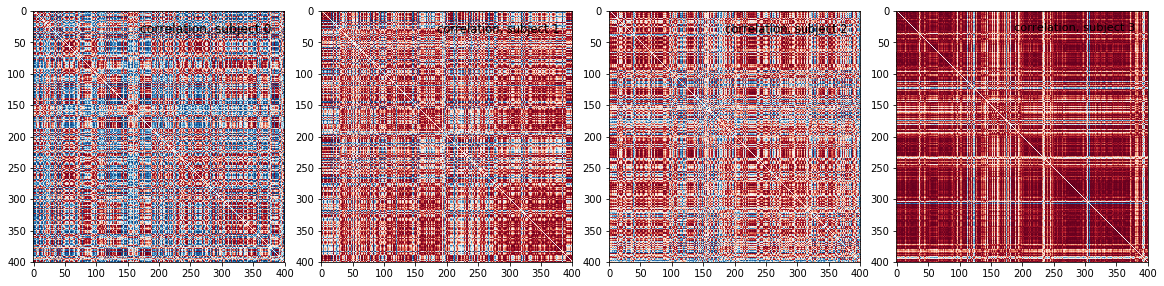

In [28]:
plot_matrices(correlation_matrices_oa[:4], 'correlation')

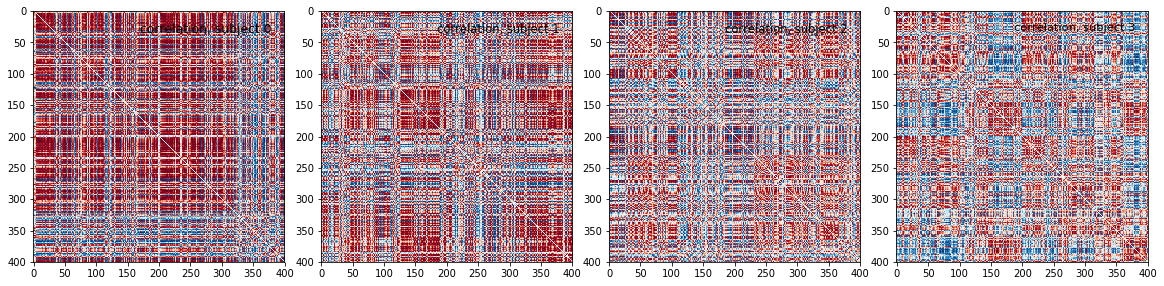

In [29]:
plot_matrices(correlation_matrices_ya[:4], 'correlation')

### Mean Group Correlation Matrices

**Older Adults**

In [30]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, *, data=None, **kwargs)>

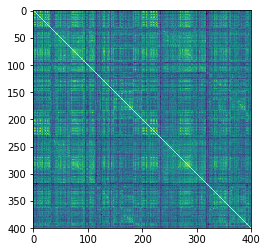

In [31]:
plt.imshow(mean_correlation_matrix_oa)

**Young Adults**

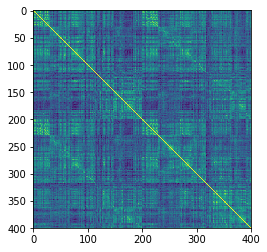

In [32]:
plt.imshow(mean_correlation_matrix_ya)

### Visualize group mean correlation matrices on glass brain

Another good time for a coffee break if not using the edge_threshold option.

It's really hard to see the edges since I can't find a way to only show nodes with significant edges.

/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


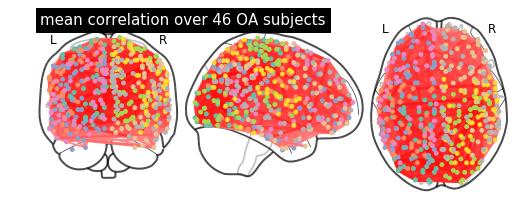

In [33]:
from nilearn import plotting

plotting.plot_connectome(mean_correlation_matrix_oa, schaefer_coords, \
                         title='mean correlation over {0} OA subjects'.format(len(correlation_matrices_oa)), \
                                                                             edge_threshold='75%', \
                                                                             node_size=15)


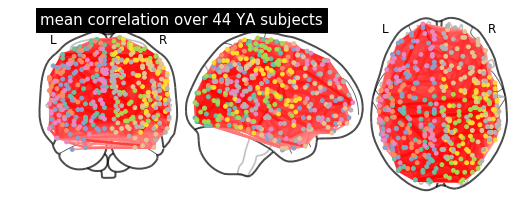

In [34]:
plotting.plot_connectome(mean_correlation_matrix_ya, schaefer_coords, title='mean correlation over {0} YA subjects'.format(len(correlation_matrices_ya)), \
                         edge_threshold='75%',
                        node_size=15)


### Use the Network-Based Statistic to analyze group functional connectivity differences

Read more about NBS in [Zalesky (2010)](10.1016/j.neuroimage.2010.06.041).

This uses the [Brain Connectivity Toolbox for Python](https://github.com/aestrivex/bctpy).

    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)

In [35]:
X = correlation_matrices_ya.reshape((400, 400, len(correlation_matrices_ya)))
Y = correlation_matrices_oa.reshape((400, 400, len(correlation_matrices_oa)))

In [36]:
from bct import nbs

pval, adj, null = nbs.nbs_bct(X, Y, thresh=20, k=3, tail='right', paired=False, verbose=False)

max component size is 24
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


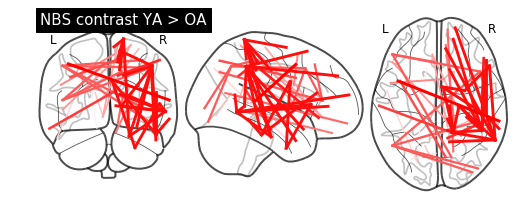

In [37]:
from nilearn import plotting
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast YA > OA', node_size=0)

In [38]:
pval, adj, null = nbs.nbs_bct(X, Y, thresh=20.0, k=3, tail='left', paired=False, verbose=False)

max component size is 79
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


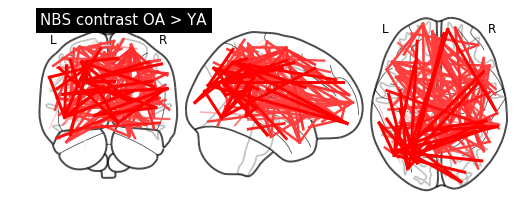

In [39]:
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast OA > YA', node_size=0)

In [40]:
dmn_mask = np.r_[148:200,361:400]
a = np.zeros((400,400))
b = a[dmn_mask, :]
b = b[:, dmn_mask]
print(b.shape)

(91, 91)


In [41]:
print('Young Adults DMN')
print(X.shape)
X_dmn = []
X_dmn = X[dmn_mask,:,:]
X_dmn = X_dmn[:,dmn_mask,:]
print(X_dmn.shape)

print('Older Adults DMN')
print(Y.shape)
Y_dmn = []
Y_dmn = Y[dmn_mask,:,:]
Y_dmn = Y_dmn[:,dmn_mask,:]
print(Y_dmn.shape)

Young Adults DMN
(400, 400, 44)
(91, 91, 44)
Older Adults DMN
(400, 400, 46)
(91, 91, 46)


### BCT graph metrics by age group

In [43]:
thresh_range = [0.10, 0.15, 0.20, 0.25]

In [44]:
import bct
from bct import algorithms
import pandas as pd

thresh_range = [0.10, 0.15, 0.20, 0.25]
for thresh in thresh_range:
    bct_data_oa = [] #just in case
    bct_data_oa = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity', 'efficiency_global_dmn', 'clustering_coef_dmn', 'modularity_dmn'))
    for sub in range(0,np.ma.size(Y, 2)):
        thresh_mat = bct.threshold_proportional(Y[:,:,sub], thresh)      
        ge = algorithms.efficiency_wei(thresh_mat, local = False)
        cc = algorithms.clustering_coef_wu(thresh_mat).mean()
        Ci, Q = algorithms.modularity_und(thresh_mat)
        
        thresh_dmn = bct.threshold_proportional(Y_dmn[:,:,sub], thresh) 
        
        ge_dmn = algorithms.efficiency_wei(thresh_dmn, local = False)
        cc_dmn = algorithms.clustering_coef_wu(thresh_dmn).mean()
        Ci_dmn, Q_dmn = algorithms.modularity_und(thresh_dmn)
        
        bct_data_oa = bct_data_oa.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q, 'efficiency_global_dmn': ge_dmn, 'clustering_coef_dmn': cc_dmn, 'modularity_dmn': Q_dmn}, index=[0]), ignore_index=True)
    np.save('data/%s_bct_oa_thr_%s' % (task, str(thresh).split('.')[1]), bct_data_oa)
        
print(bct_data_oa[:5])


/usr/local/lib/python3.7/site-packages/bct/algorithms/clustering.py:216: RuntimeWarning: divide by zero encountered in true_divide
  C = cyc3 / (K * (K - 1))


   efficiency_global  clustering_coef  modularity  efficiency_global_dmn  \
0           0.580617         0.295138    0.084019               0.565330   
1           0.581497         0.298342    0.087951               0.565465   
2           0.580848         0.292452    0.089912               0.568674   
3           0.581357         0.297864    0.086236               0.566122   
4           0.580742         0.295300    0.086874               0.564501   

   clustering_coef_dmn  modularity_dmn  
0             0.457772        0.115234  
1             0.327687        0.114501  
2             0.299628        0.098638  
3             0.318483        0.103999  
4             0.333387        0.116132  


In [45]:
import bct
from bct import algorithms
import pandas as pd

thresh_range = [0.10, 0.15, 0.20, 0.25]
for thresh in thresh_range:
    bct_data_ya = [] #just in case
    bct_data_ya = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity', 'efficiency_global_dmn', 'clustering_coef_dmn', 'modularity_dmn'))
    for sub in range(0,np.ma.size(X, 2)):
        thresh_mat = bct.threshold_proportional(X[:,:,sub], thresh)      
        ge = algorithms.efficiency_wei(thresh_mat, local = False)
        cc = algorithms.clustering_coef_wu(thresh_mat).mean()
        Ci, Q = algorithms.modularity_und(thresh_mat)
        
        thresh_dmn = bct.threshold_proportional(X_dmn[:,:,sub], thresh) 
        
        ge_dmn = algorithms.efficiency_wei(thresh_dmn, local = False)
        cc_dmn = algorithms.clustering_coef_wu(thresh_dmn).mean()
        Ci_dmn, Q_dmn = algorithms.modularity_und(thresh_dmn)
        
        bct_data_ya = bct_data_ya.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q, 'efficiency_global_dmn': ge_dmn, 'clustering_coef_dmn': cc_dmn, 'modularity_dmn': Q_dmn}, index=[0]), ignore_index=True)
    np.save('data/%s_bct_ya_thr_%s' % (task, str(thresh).split('.')[1]), bct_data_ya)
        
print(bct_data_ya[:5])


   efficiency_global  clustering_coef  modularity  efficiency_global_dmn  \
0           0.574987         0.292343    0.058838               0.559997   
1           0.575094         0.287535    0.066052               0.561224   
2           0.574976         0.285884    0.060506               0.556827   
3           0.574878         0.292515    0.061061               0.560284   
4           0.575252         0.290778    0.056661               0.561785   

   clustering_coef_dmn  modularity_dmn  
0             0.485702        0.080415  
1             0.347586        0.092631  
2             0.331369        0.083711  
3             0.456222        0.095802  
4             0.347051        0.079532  


In [46]:
from scipy import stats

t, p = stats.ttest_ind(bct_data_ya, bct_data_oa, equal_var=False)
print('global efficiency, clustering, modularity \n t-statistics: %s \n p-values: %s' %(t, p))

global efficiency, clustering, modularity 
 t-statistics: [-90.72478781 -10.89494459 -34.06482743 -16.44542354          nan
 -12.42699463] 
 p-values: [1.45409972e-76 7.08732324e-18 5.56471243e-48 7.80635539e-28
            nan 5.06272333e-21]


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Visualize BCT metrics
Older adults are shown in orange.

{'bodies': [<matplotlib.collections.PolyCollection at 0x124d19080>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x124ccfd68>,
 'cmins': <matplotlib.collections.LineCollection at 0x124d19518>,
 'cbars': <matplotlib.collections.LineCollection at 0x124d19780>}

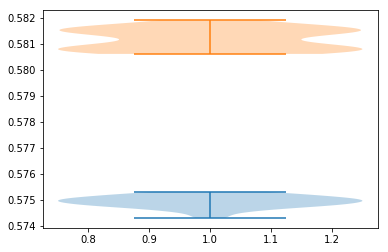

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.violinplot(bct_data_ya['efficiency_global'])
plt.violinplot(bct_data_oa['efficiency_global'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x17a8ed828>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x17a8e4cc0>,
 'cmins': <matplotlib.collections.LineCollection at 0x17a8edcc0>,
 'cbars': <matplotlib.collections.LineCollection at 0x17a8edf28>}

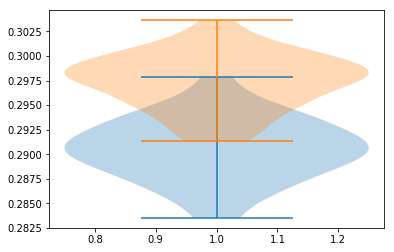

In [48]:
plt.violinplot(bct_data_ya['clustering_coef'])
plt.violinplot(bct_data_oa['clustering_coef'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x17ab685f8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x179becac8>,
 'cmins': <matplotlib.collections.LineCollection at 0x17ab68a90>,
 'cbars': <matplotlib.collections.LineCollection at 0x17ab68cf8>}

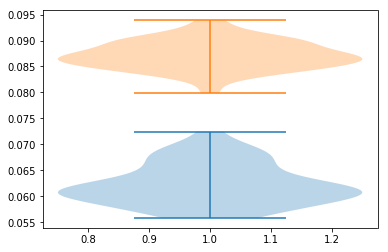

In [53]:
plt.violinplot(bct_data_ya['modularity'])
plt.violinplot(bct_data_oa['modularity'])